## Count terms appearing in tweets

This notebook produces the graph with frequency counts of Dutch tweets related to the COVID-19 crisis. It relies on the texts of the tweets in the directory data/text and will count all the tweets in that directory. The notebook should be run every month after the tweets in the directory have been updated. Tweet counts are cached but generating the counts for one month will still take more than seven hours.

In [24]:
import gzip
import json
import os
import pandas as pd
import re
from IPython.display import clear_output

DATADIR = "../data/text/"
CSVDIR = "csv/"

In [2]:
TEXT = "text"
FULLTEXT = "full_text"
EXTENDEDTWEET = "extended_tweet"
RETWEETEDSTATUS = "retweeted_status"

def getTweetText(jsonData):
    text = ""
    if TEXT in jsonData: 
        text = jsonData[TEXT]
    if EXTENDEDTWEET in jsonData and \
       FULLTEXT in jsonData[EXTENDEDTWEET]:
        text = jsonData[EXTENDEDTWEET][FULLTEXT]
    if RETWEETEDSTATUS in jsonData and \
       EXTENDEDTWEET in jsonData[RETWEETEDSTATUS] and \
       FULLTEXT in jsonData[RETWEETEDSTATUS][EXTENDEDTWEET]:
        text = jsonData[RETWEETEDSTATUS][EXTENDEDTWEET][FULLTEXT]
    return(text)

In [3]:
from datetime import datetime, timedelta

DATEFORMAT = "%a %b %d %H:%M:%S %z %Y"
SUMMERTIMEDATE = datetime.strptime("Sun Mar 29 02:00:00 +0000 2020",DATEFORMAT)
WINTERTIMEDATE = datetime.strptime("Sun Oct 25 03:00:00 +0000 2020",DATEFORMAT)

def getTweetDate(jsonData):
    dateString = jsonData["created_at"]
    dateData = datetime.strptime(dateString,DATEFORMAT)+timedelta(hours=1)
    if dateData >= SUMMERTIMEDATE:
        if dateData >= WINTERTIMEDATE: sys.exit("cannot happen")
        dateData += timedelta(hours=1)
    return(int(dateData.strftime("%Y%m%d")))

In [22]:
CSVSUFFIX = ".csv"
DUTCH = "nl"
IDSTR = "id_str"
TOPIC = "topic"
DISTANCE = "distance"
LOCKDOWN = "lockdown"
TOPICQUERY = "corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol"
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
LOCKDOWNQUERY = "lock.down|lockdown"

fileNames = sorted(os.listdir(DATADIR))

def saveCounts(counts,outFileName):
    pd.DataFrame.from_dict(counts,orient="index").to_csv(CSVDIR+outFileName,header=False)

def readCounts(inFileName):
    countsDf = pd.read_csv(CSVDIR+inFileName,header=None,index_col=0)
    return(countsDf.to_dict()[1])

def combineDicts(a,b):
    return(dict(list(a.items())+list(b.items())))

def search(query,countsIn):
    countsOut = {}
    countsInKeys = [ str(x) for x in countsIn ]
    seen = {}
    for inFileName in fileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys:
            inFile = gzip.open(DATADIR+inFileName,mode="rt")
            for line in inFile:
                jsonData = json.loads(line)
                tweetText = getTweetText(jsonData)
                tweetDate = getTweetDate(jsonData)
                tweetLang = jsonData["lang"]
                if tweetLang == DUTCH and re.search(query,tweetText,flags=re.IGNORECASE):
                    if tweetDate in countsOut: countsOut[tweetDate] += 1
                    else: countsOut[tweetDate] = 1
            inFile.close()
            if not date in seen:
                print(date)
                seen[date] = True
    countsOut = combineDicts(countsIn,countsOut)
    countsOut = {k:v for k, v in sorted(countsOut.items(), key=lambda item: item[0])}
    return(countsOut)

def searchText(query,countsIn):
    countsOut = {}
    countsInKeys = [ str(x) for x in countsIn ]
    query = query.lower()
    if query == TOPIC: query = TOPICQUERY
    elif query == DISTANCE: query = DISTANCEQUERY
    elif query == LOCKDOWN: query = LOCKDOWNQUERY
    for inFileName in fileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys:
            if not date in countsOut: 
                countsOut[date] = 0
                print(date,query)
            df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)
            for i in range(0,len(df)):
                if re.search(query,str(df.iloc[i][TEXT]).lower()):
                    countsOut[date] += 1
    countsOut = combineDicts(countsIn,countsOut)
    countsOut = {str(k):v for k, v in sorted(countsOut.items(), key=lambda item: str(item[0]))}
    return(countsOut)

def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [29]:
month_data = {}
for file_name in fileNames:
    if re.search("^2",file_name):
        squeal(file_name)
        month = file_name[:6]
        if not month in month_data:
            month_data[month] = { "counts":0, "hours":0, "dates":{} }  
        df = pd.read_csv(DATADIR+file_name, compression="gzip", engine="python")
        month_data[month]["counts"] += len(df)
        month_data[month]["hours"] += 1
        date = file_name[:8]
        month_data[month]["dates"][date] = True

for month in month_data: # extra hour for change to Winter time
    if re.search("10$",month): month_data[month]["hours"] += 1

{m:[month_data[m]["counts"], int(month_data[m]["counts"]/len(month_data[m]["dates"])), int(month_data[m]["counts"]/month_data[m]["hours"])] for m in month_data}

20201231-23.out.gz


{'202011': 19354361}

In [8]:
rivm = readCounts("rivm.csv")
corona = readCounts("corona.csv")
covid = readCounts("covid.csv")
mondkapje = readCounts("mondkapje.csv")
topic = readCounts(TOPIC+CSVSUFFIX)
distance = readCounts(DISTANCE+CSVSUFFIX)
lockdown = readCounts(LOCKDOWN+CSVSUFFIX)

In [6]:
def deleteLastElement(myDict):
    if myDict: del(myDict[list(myDict.keys())[-1]])

def processData(dataContainer,queryName):
    deleteLastElement(dataContainer)
    dataContainer = searchText(queryName,dataContainer)
    saveCounts(dataContainer,queryName+CSVSUFFIX)

def processDataNew(queryName):
    dataContainer = searchText(queryName,{})
    saveCounts(dataContainer,queryName+CSVSUFFIX)
    return(dataContainer)

if False:
    processData(lockdown,LOCKDOWN)
    processData(distance,DISTANCE)
    processData(topic,TOPIC)
    processData(covid,"covid")
    processData(mondkapje,"mondkapje")
    processData(corona,"corona")
    processData(rivm,"rivm")

20201130 lock.down|lockdown
20201201 lock.down|lockdown
20201202 lock.down|lockdown
20201203 lock.down|lockdown
20201204 lock.down|lockdown
20201205 lock.down|lockdown
20201206 lock.down|lockdown
20201207 lock.down|lockdown
20201208 lock.down|lockdown
20201209 lock.down|lockdown
20201210 lock.down|lockdown
20201211 lock.down|lockdown
20201212 lock.down|lockdown
20201213 lock.down|lockdown
20201214 lock.down|lockdown
20201215 lock.down|lockdown
20201216 lock.down|lockdown
20201217 lock.down|lockdown
20201218 lock.down|lockdown
20201219 lock.down|lockdown
20201220 lock.down|lockdown
20201221 lock.down|lockdown
20201222 lock.down|lockdown
20201223 lock.down|lockdown
20201224 lock.down|lockdown
20201225 lock.down|lockdown
20201226 lock.down|lockdown
20201227 lock.down|lockdown
20201228 lock.down|lockdown
20201229 lock.down|lockdown
20201230 lock.down|lockdown
20201231 lock.down|lockdown
20201130 1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter
20201201 1[.,]5[ -]*m|afstand.*hou|

In [9]:
monthCounts = {}
for date in topic:
    month = str(date)[0:6]
    if not month in monthCounts: monthCounts[month] = 0
    monthCounts[month] += topic[date]
monthCounts

{'202002': 278082,
 '202003': 3152638,
 '202004': 2115728,
 '202005': 1264650,
 '202006': 921481,
 '202007': 922992,
 '202008': 1078644,
 '202009': 1115057,
 '202010': 1571318,
 '202011': 809093,
 '202012': 1174805}

In [10]:
import math
from warnings import warn

WEEKLENGTH = 7

def summarize(myDict,index,count):
    counter = 0
    mySum = 0
    myKeys = list(myDict.keys())
    for i in range(0,count):
        if index-i >= 0 and not math.isnan(myDict[myKeys[index-i]]):
            counter += 1
            mySum += myDict[myKeys[index-i]]
            if myKeys[index-i] > myKeys[index]:
                warn("keys are not sorted!")
    if counter == 0: return(math.nan)
    else: return(mySum/counter)

rivm7 = {list(rivm.keys())[i]:summarize(rivm,i,WEEKLENGTH) for i in range(0,len(rivm))}
corona7 = {list(corona.keys())[i]:summarize(corona,i,WEEKLENGTH) for i in range(0,len(corona))}
covid7 = {list(covid.keys())[i]:summarize(covid,i,WEEKLENGTH) for i in range(0,len(covid))}
mondkapje7 = {list(mondkapje.keys())[i]:summarize(mondkapje,i,WEEKLENGTH) for i in range(0,len(mondkapje))}
topic7 = {list(topic.keys())[i]:summarize(topic,i,WEEKLENGTH) for i in range(0,len(topic))}
distance7 = {list(distance.keys())[i]:summarize(distance,i,WEEKLENGTH) for i in range(0,len(distance))}
lockdown7 = {list(lockdown.keys())[i]:summarize(lockdown,i,WEEKLENGTH) for i in range(0,len(lockdown))}

### Plot absolute values

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

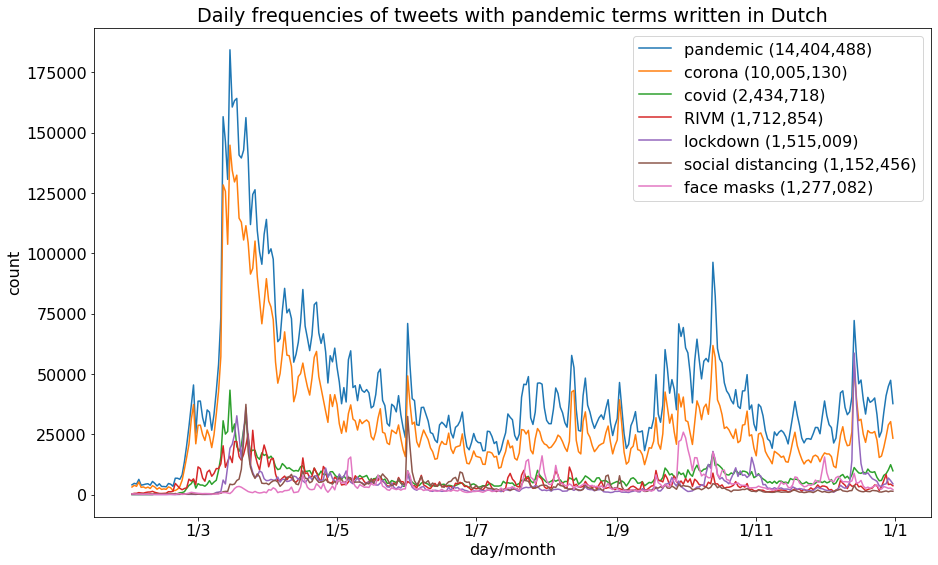

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
#%matplotlib inline

DATEFORMATPLOT = "%Y%m%d"
PLOTFILEOUT = "tweet-frequencies.png"

def getWeekendDates(dateStrings):
    weekendDates = []
    for ds in dateStrings:
        d = datetime.strptime(str(ds),DATEFORMATPLOT)
        if d == 0 or d == 6: weekendDates.append(d)
            
def stringArrayToDates(stringList,dateFormat=DATEFORMATPLOT):
    return([datetime.strptime(str(date),dateFormat) for date in stringList])

def prettyPrintNumber(number):
    digits = str(number)
    prettyNumber = ""
    for i in range(-1,-len(digits)-1,-1):
        prettyNumber = digits[i]+prettyNumber
        if i % 3 == 0 and i > -len(digits): prettyNumber = ","+prettyNumber
    return(prettyNumber)

def makeLabel(name,myDict):
    if name == TOPIC: label = "pandemic"
    elif name == DISTANCE: label = "social distancing"
    elif name == "rivm": label = "RIVM"
    elif name == "mondkapje": label = "face masks"
    else: label = name
    return(label+" ("+prettyPrintNumber(sum(myDict.values()))+")")

weekendDates = getWeekendDates(rivm.keys())
font = {"size":16}
matplotlib.rc("font",**font)
plt.figure(figsize=(15,9))
ax1 = plt.subplot(111)
ax1.plot_date(stringArrayToDates(topic.keys()),list(topic.values()),xdate=True,fmt="-",label=makeLabel(TOPIC,topic))
ax1.plot_date(stringArrayToDates(corona.keys()),list(corona.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax1.plot_date(stringArrayToDates(covid.keys()),list(covid.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax1.plot_date(stringArrayToDates(rivm.keys()),list(rivm.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
ax1.plot_date(stringArrayToDates(lockdown.keys()),list(lockdown.values()),xdate=True,fmt="-",label=makeLabel(LOCKDOWN,lockdown))
ax1.plot_date(stringArrayToDates(distance.keys()),list(distance.values()),xdate=True,fmt="-",label=makeLabel(DISTANCE,distance))
ax1.plot_date(stringArrayToDates(mondkapje.keys()),list(mondkapje.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
dummy = ax1.legend()
plt.title("Daily frequencies of tweets with pandemic terms written in Dutch")
plt.xlabel("day/month")
plt.ylabel("count")
plt.savefig(PLOTFILEOUT)
plt.show()

### Plot normalized values

This code needs the contents of the file date-counts.csv to be up-to-date. The data for the file can be computed with shell code executed in a terminal in the directory data/text (adjust month in command):
```for FILE in 202101??-00*; do DATE=`echo $FILE|cut -c1-8`; COUNT=`gunzip -c ${DATE}*|grep -v '^[0-9]'|wc -l`; echo $DATE,$COUNT; done >> ../date-counts.csv```

In [16]:
import pandas as pd

def normalize(dateCounts,countsIn):
    countsOut = {}
    for key in countsIn:
        if int(key) in dateCounts.index: 
            countsOut[key] = countsIn[key]/dateCounts.loc[int(key)]["count"]
    return(countsOut)

dateCounts = pd.read_csv(DATADIR+"../date-counts.csv",index_col=["date"])

In [17]:
rivmNorm = normalize(dateCounts,rivm)
coronaNorm = normalize(dateCounts,corona)
covidNorm = normalize(dateCounts,covid)
mondkapjeNorm = normalize(dateCounts,mondkapje)
topicNorm = normalize(dateCounts,topic)
distanceNorm = normalize(dateCounts,distance)
lockdownNorm = normalize(dateCounts,lockdown)

rivmNorm7 = {list(rivmNorm.keys())[i]:summarize(rivmNorm,i,WEEKLENGTH) for i in range(0,len(rivmNorm))}
coronaNorm7 = {list(coronaNorm.keys())[i]:summarize(coronaNorm,i,WEEKLENGTH) for i in range(0,len(coronaNorm))}
covidNorm7 = {list(covidNorm.keys())[i]:summarize(covidNorm,i,WEEKLENGTH) for i in range(0,len(covidNorm))}
mondkapjeNorm7 = {list(mondkapjeNorm.keys())[i]:summarize(mondkapjeNorm,i,WEEKLENGTH) for i in range(0,len(mondkapjeNorm))}
topicNorm7 = {list(topicNorm.keys())[i]:summarize(topicNorm,i,WEEKLENGTH) for i in range(0,len(topicNorm))}
distanceNorm7 = {list(distanceNorm.keys())[i]:summarize(distanceNorm,i,WEEKLENGTH) for i in range(0,len(distanceNorm))}
lockdownNorm7 = {list(lockdownNorm.keys())[i]:summarize(lockdownNorm,i,WEEKLENGTH) for i in range(0,len(lockdownNorm))}

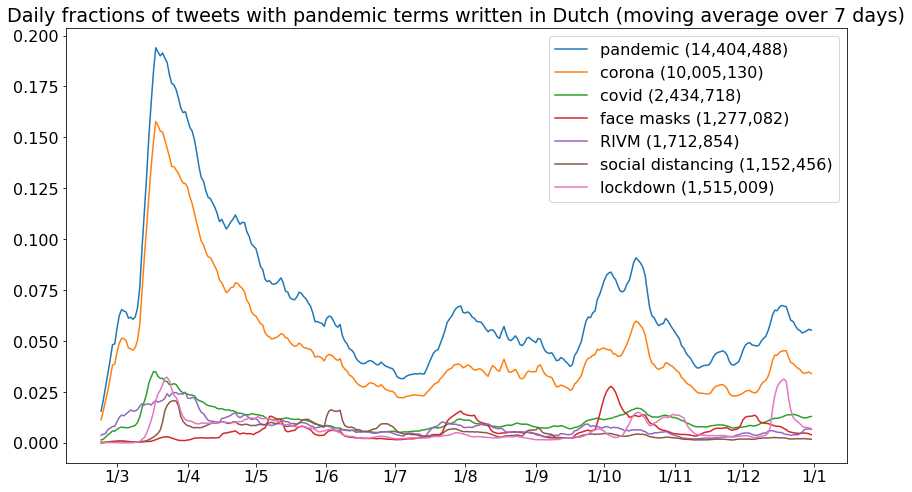

In [18]:
plt.figure(figsize=(14,8))
ax2 = plt.subplot(111)
ax2.plot_date(stringArrayToDates(topicNorm7.keys()),list(topicNorm7.values()),xdate=True,fmt="-",label=makeLabel("topic",topic))
ax2.plot_date(stringArrayToDates(coronaNorm7.keys()),list(coronaNorm7.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax2.plot_date(stringArrayToDates(covidNorm7.keys()),list(covidNorm7.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax2.plot_date(stringArrayToDates(mondkapjeNorm7.keys()),list(mondkapjeNorm7.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
ax2.plot_date(stringArrayToDates(rivmNorm7.keys()),list(rivmNorm7.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
ax2.plot_date(stringArrayToDates(distanceNorm7.keys()),list(distanceNorm7.values()),xdate=True,fmt="-",label=makeLabel("distance",distance))
ax2.plot_date(stringArrayToDates(lockdownNorm7.keys()),list(lockdownNorm7.values()),xdate=True,fmt="-",label=makeLabel(LOCKDOWN,lockdown))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.title("Daily fractions of tweets with pandemic terms written in Dutch (moving average over 7 days)")
#plt.xticks([datetime.strptime(d,DATEFORMATPLOT) for d in "20200301 20200401 20200501 20200601 20200701 20200801 20200901 20201001 20201101".split()])
dummy = ax2.legend()

## Content analysis

In [23]:
import gzip
import json
import os
import numpy as np
import pandas as pd
import re

DATADIR = "../data/all/"
ID = "id_str"
LANG = "lang"
USER = "user"
SCREENNAME = "screen_name"
RIVM = "rivm"
DUTCH = "nl"
TARGETDATES = ["20200412","20200413","20200414","20200415","20200416","20200417","20200418"]
QUERY = "mondkapje"

def removeNewlines(text):
    return(re.sub(r"\n"," ",text))

fileNames = os.listdir(DATADIR)
texts = {}
dates = {}
for inFileName in fileNames:
    inFileDate = inFileName[0:8]
    if inFileDate in TARGETDATES:
        inFile = gzip.open(DATADIR+inFileName,mode="rt")
        for line in inFile:
            jsonData = json.loads(line)
            tweetText = removeNewlines(getTweetText(jsonData))
            tweetLang = jsonData[LANG]
            tweetId = jsonData[ID]
            tweetUser = jsonData[USER][SCREENNAME]
            if tweetLang == DUTCH and \
               re.search(QUERY,tweetText,flags=re.IGNORECASE) and \
               re.search(RIVM,tweetText,flags=re.IGNORECASE):
                texts[tweetId] = {"user":tweetUser,"text":tweetText}
                dates[tweetId] = int(inFileDate)
        inFile.close()
len(texts)

7841

In [24]:
pd.DataFrame.from_dict(texts,orient="index").to_csv("mondkapje-tweets.csv",header=False)

In [25]:
ANNOTATIONFILE = DATADIR+"../"+"mondkapje-tweets.csv.human-labels.txt"

def readAnnotations(annotationFile):
    inFile = open(annotationFile,"r")
    annotations = {}
    minutes = {}
    for line in inFile:
        (userName,date,tweetId,nbr,label) = line.strip().split()
        if not userName in annotations: 
            annotations[userName] = {}
            minutes[userName] = {}
        annotations[userName][tweetId] = label
        minutes[userName][date[0:12]] = True
    inFile.close()
    for userName in annotations:
        print("annotation time of user {0}: {1:d} messages in {2:d} minutes ({3:0.1f} tweets per minute)".\
              format(userName,len(annotations[userName]),len(minutes[userName]),round(len(annotations[userName])/len(minutes[userName]),1)))
    return(annotations)

annotations = readAnnotations(ANNOTATIONFILE)

annotation time of user erikt@xs4all.nl: 1936 messages in 164 minutes (11.8 tweets per minute)
annotation time of user m.p.schraagen@uu.nl: 578 messages in 129 minutes (4.5 tweets per minute)


In [26]:
for annotationFile in "202007-distance-twitter.csv.human-labels.txt 202007-distance-nunl.csv.human-labels.txt \
                       202007-distance-reddit.csv.human-labels.txt".split():
    dummy = readAnnotations("../data/"+annotationFile)

annotation time of user n.k.breedveld@uu.nl: 299 messages in 81 minutes (3.7 tweets per minute)
annotation time of user erikt@xs4all.nl: 300 messages in 79 minutes (3.8 tweets per minute)
annotation time of user n.k.breedveld@uu.nl: 142 messages in 66 minutes (2.2 tweets per minute)
annotation time of user n.k.breedveld@uu.nl: 200 messages in 105 minutes (1.9 tweets per minute)


In [27]:
dummy = readAnnotations("../data/"+"distance-tweets.csv.human-labels.txt")

annotation time of user erikt@xs4all.nl: 5977 messages in 1128 minutes (5.3 tweets per minute)
annotation time of user n.k.breedveld@uu.nl: 998 messages in 272 minutes (3.7 tweets per minute)
annotation time of user test@test.com: 100 messages in 5 minutes (20.0 tweets per minute)


In [28]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
NEGATIVE = "NEGATIVE"
POSITIVE = "POSITIVE"

labelsPerDate = {}
totals = {}
for tweetId in dates:
    if tweetId in annotations and annotations[tweetId] != IRRELEVANT:
        date = int(dates[tweetId])
        label = annotations[tweetId]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        labelsPerDate[date][label] = labelsPerDate[date][label]+1 if label in labelsPerDate[date] else 1
        totals[label] = totals[label]+1 if label in totals else 1
labelsPerDate

{}

In [30]:
import matplotlib
import matplotlib.pyplot as plt

labels = {"NEGATIVE":"rejects","POSITIVE":"supports","NEUTRAL":"neutral"}
percentages = {key:round(100*totals[key]/sum(totals.values())) for key in totals}
font = {"size":16}
matplotlib.rc("font",**font)

for date in labelsPerDate:
    for label in [NEGATIVE,NEUTRAL,POSITIVE]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][NEGATIVE] for date in labelsPerDate.keys()]
neutral = [labelsPerDate[date][NEUTRAL] for date in labelsPerDate.keys()]
positive = [labelsPerDate[date][POSITIVE] for date in labelsPerDate.keys()]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.figure(figsize=(12,8))
plt.bar(list(labelsPerDate.keys()),positive,label=labels[POSITIVE]+" ("+str(percentages[POSITIVE])+"%)",bottom=negplusneu)
plt.bar(list(labelsPerDate.keys()),neutral,label=labels[NEUTRAL]+" ("+str(percentages[NEUTRAL])+"%)",bottom=negative)
plt.bar(list(labelsPerDate.keys()),negative,label=labels[NEGATIVE]+" ("+str(percentages[NEGATIVE])+"%)",color="r")
plt.title("Twitter stance on RIVM advising against facemask use by general public")
plt.xticks(list(labelsPerDate.keys()),["Fri 17/4","Wed 15/4","Sun 12/4","Thu 16/4","Mon 13/4","Tue 14/4"])
plt.legend()
plt.show()

KeyError: 'POSITIVE'

<Figure size 864x576 with 0 Axes>

## twiqs.nl tweets per month (alltime)

In [37]:
from datetime import datetime
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt

In [38]:
DATAFILE = "../data/months.txt"
DATEFORMAT = "%Y%m"

In [41]:
df = pd.read_csv(DATAFILE,sep=" ",header=None,index_col=0)

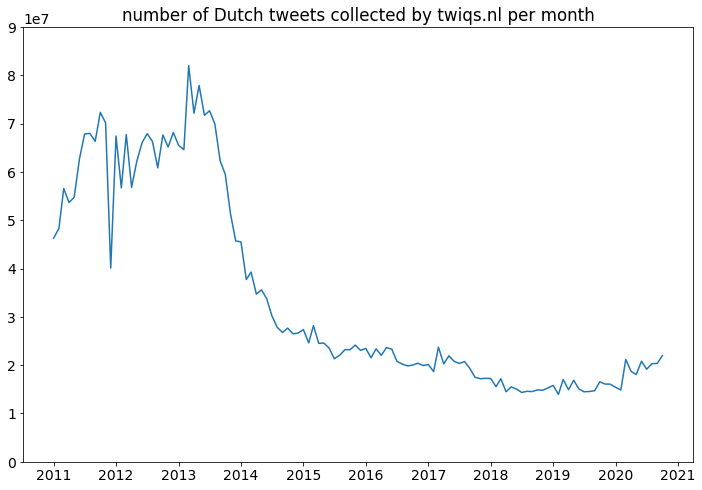

In [42]:
font = {"size":14}
matplotlib.rc("font",**font)
plt.figure(figsize=(12,8))
ax2 = plt.subplot(111)
ax2.set_ylim([0,90000000])
ax2.plot_date([datetime.strptime(str(month),DATEFORMAT) for month in df.index if month > 201100],\
               [df.loc[month][1] for month in df.index if month > 201100],fmt="-")
plt.title("number of Dutch tweets collected by twiqs.nl per month")
plt.show()